In [1]:
# Basics
import pandas as pd
import numpy as np


In [2]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set_theme(style="darkgrid")


In [3]:
# ML
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

# Classification
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV

random_state = 42


### Load data

In [7]:
wine = pd.read_csv("winequality-red.csv")

wine_X = wine.loc[:, "fixed acidity":"alcohol"]
wine_y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine_y,
    random_state=random_state,
    stratify=wine_y
    )


## EDA

<AxesSubplot:xlabel='quality', ylabel='Count'>

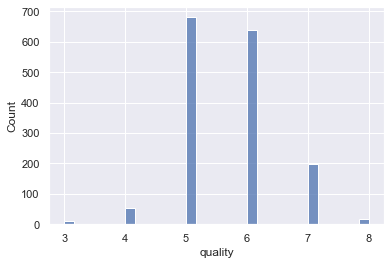

In [8]:
sns.histplot(
    data=wine_y,
)


C:\tools\miniconda3\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


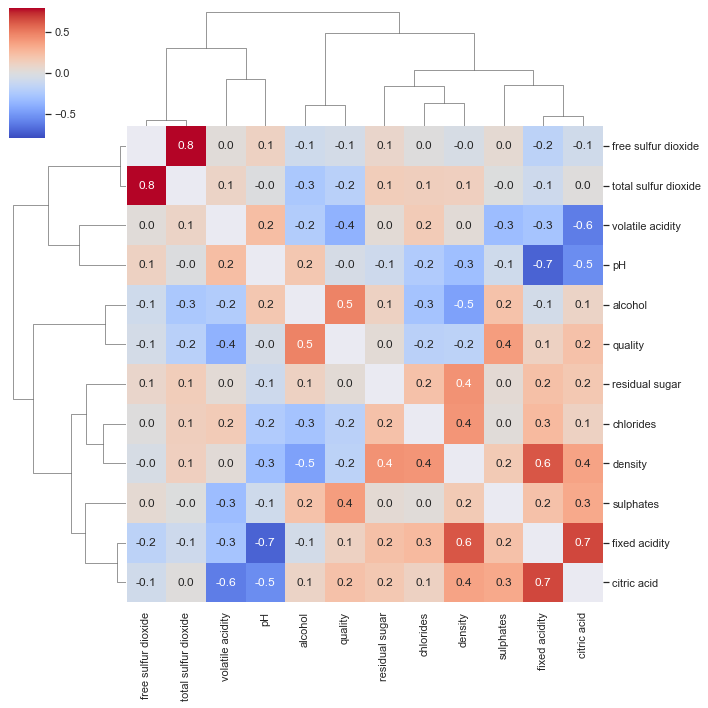

In [9]:
mask = np.identity(12)
sns.clustermap(
    # pd.DataFrame(robust_scale(wine)).corr(),
    wine.corr(method="spearman"),
    metric="cosine",
    annot=True,
    mask=mask,
    fmt="1.1f",
    square=True,
    # z_score=1,
    cmap="coolwarm",
    norm=colors.CenteredNorm(),
)


<AxesSubplot:>

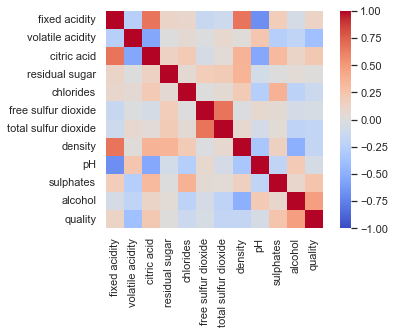

In [10]:
sns.heatmap(wine.corr(),
            square=True,
            # annot=True,
            fmt=".1f",
            cmap="coolwarm",
            norm=colors.CenteredNorm(),)


## Train ML Models
### Regressors

In [30]:
estimators = [
    ("knnr", KNeighborsRegressor(
        weights="distance",
        n_neighbors=100,
    )
    ),
    ("gpr", GaussianProcessRegressor(
        n_restarts_optimizer=10,
        normalize_y=True,
        random_state=random_state
    )
    ),
    ("rfr", RandomForestRegressor(
        random_state=random_state,
        n_jobs=-1
    )
    ),
    ("SVR", LinearSVR(
        max_iter=100000,
        random_state=random_state
    ))
]

scaler = RobustScaler()


In [31]:
for i in estimators:
    pipeline = make_pipeline(scaler, i[1])
    pipeline.fit(X=X_train, y=y_train)
    pred = pipeline.predict(X=X_test)

    print("Estimator: " f"{i[0]} \n"
          "Score: " f"{pipeline.score(X_test, y_test):.2} \n"
          "MSE: " f"{mean_squared_error(y_test, pred):.2} \n")


Estimator: knnr 
Score: 0.45 
MSE: 0.36 

Estimator: gpr 
Score: 0.14 
MSE: 0.56 

Estimator: rfr 
Score: 0.48 
MSE: 0.34 

Estimator: SVR 
Score: 0.36 
MSE: 0.41 



In [32]:
reg_comp = StackingRegressor(
    estimators=estimators,
    n_jobs=-1,
)

pipeline = make_pipeline(
    scaler, reg_comp
)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)

print("Score: " f"{pipeline.score(X_test, y_test):.2}")
print("MSE: " f"{mean_squared_error(y_test, pred):.2}")


Score: 0.52
MSE: 0.31


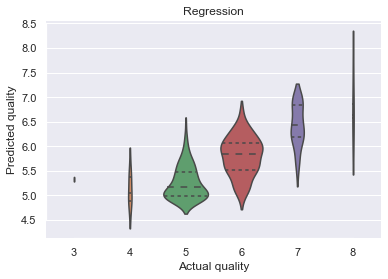

In [33]:
sns.violinplot(
    x=y_test,
    y=pred,
    palette="deep",
    cut=1,
    inner="quartile",
    scale="count",
)

plt.title("Regression")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")
sns.despine(trim=True)


### Classifiers

In [15]:
estimators = [
    ("knnc", KNeighborsClassifier(
        weights="distance",
        n_neighbors=100,
        n_jobs=-1
    )),
    ("gpc", GaussianProcessClassifier(
        random_state=random_state,
        warm_start=True
    )),
    ("rfc", RandomForestClassifier(
        random_state=random_state,
        class_weight="balanced_subsample",
        n_jobs=-1
    )),
    ("SVC", LinearSVC(
        max_iter=100000,
        random_state=random_state
    ))
]

final_estimator = LogisticRegressionCV(
    max_iter=1000,
    # solver="liblinear"
)

scaler = RobustScaler(
    unit_variance=True
)


In [16]:
for i in estimators:
    pipeline = make_pipeline(scaler, i[1])
    pipeline.fit(X=X_train, y=y_train)
    pred = pipeline.predict(X=X_test)

    print("Estimator: " f"{i[0]} \n"
          "Score: " f"{pipeline.score(X_test, y_test):.2} \n"
          "MSE: " f"{mean_squared_error(y_test, pred):.2} \n")


Estimator: knnc 
Score: 0.67 
MSE: 0.42 

Estimator: gpc 
Score: 0.66 
MSE: 0.52 

Estimator: rfc 
Score: 0.68 
MSE: 0.39 

Estimator: SVC 
Score: 0.58 
MSE: 0.52 



In [27]:
class_comp = StackingClassifier(
    estimators=estimators,
    # final_estimator=final_estimator,
    n_jobs=-1,
    verbose=0,
)

pipeline = make_pipeline(
    scaler, class_comp,
    verbose=False,
)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)

print("Stacking Classifier \n"
      "Score: " f"{pipeline.score(X_test, y_test):.2} \n"
      "MSE: " f"{mean_squared_error(y_test, pred):.2}")


C:\tools\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifier 
Score: 0.69 
MSE: 0.36


Text(0, 0.5, 'Predicted quality')

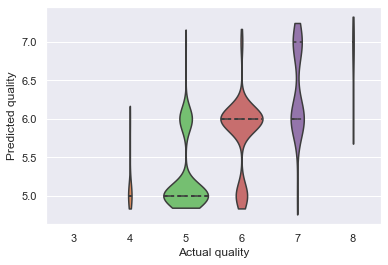

In [25]:
sns.violinplot(
    x=y_test,
    y=pred,
    palette="muted",
    cut=1,
    inner="quartile",
    scale="count",
)

plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")


In [19]:
from sklearn.metrics import matthews_corrcoef
print("MCC for classification: "f"{matthews_corrcoef(y_test, pred):.2}")


MCC for classification: 0.49


## Conclusions
- Regression and classification work both
- Ensemble of different algorithms outperforms single algorithm
- Imbalance of the classes is problematic
- Classes 5, 6 and 7 are easy to train and detect
- 3, 4 and 8 are hard (sometimes not even in the training split)